In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/jena_climate_2009_2016.csv')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
df['Date Time']=pd.to_datetime(df['Date Time'])
df['Date Time'].head


df['T (degC)'].fillna(df['T (degC)'].mean(), inplace=True) # we will fill the null row

df = df[['Date Time','T (degC)' ]]
df.head

<bound method NDFrame.head of                  Date Time  T (degC)
0      2009-01-01 00:10:00     -8.02
1      2009-01-01 00:20:00     -8.41
2      2009-01-01 00:30:00     -8.51
3      2009-01-01 00:40:00     -8.31
4      2009-01-01 00:50:00     -8.27
...                    ...       ...
420546 2016-12-31 23:20:00     -4.05
420547 2016-12-31 23:30:00     -3.35
420548 2016-12-31 23:40:00     -3.16
420549 2016-12-31 23:50:00     -4.23
420550 2017-01-01 00:00:00     -4.82

[420551 rows x 2 columns]>

In [5]:
df.columns

Index(['Date Time', 'T (degC)'], dtype='object')

In [6]:
df.columns = ['Date Time', 'T_degC']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date Time  420551 non-null  datetime64[ns]
 1   T_degC     420551 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 MB


In [8]:
jena=df[['Date Time','T_degC']].copy()
jena['Date'] = jena['Date Time'].dt.date

jena_f=jena.drop('Date Time',axis=1)
jena_f.set_index('Date', inplace= True)

jena_f.head

<bound method NDFrame.head of             T_degC
Date              
2009-01-01   -8.02
2009-01-01   -8.41
2009-01-01   -8.51
2009-01-01   -8.31
2009-01-01   -8.27
...            ...
2016-12-31   -4.05
2016-12-31   -3.35
2016-12-31   -3.16
2016-12-31   -4.23
2017-01-01   -4.82

[420551 rows x 1 columns]>

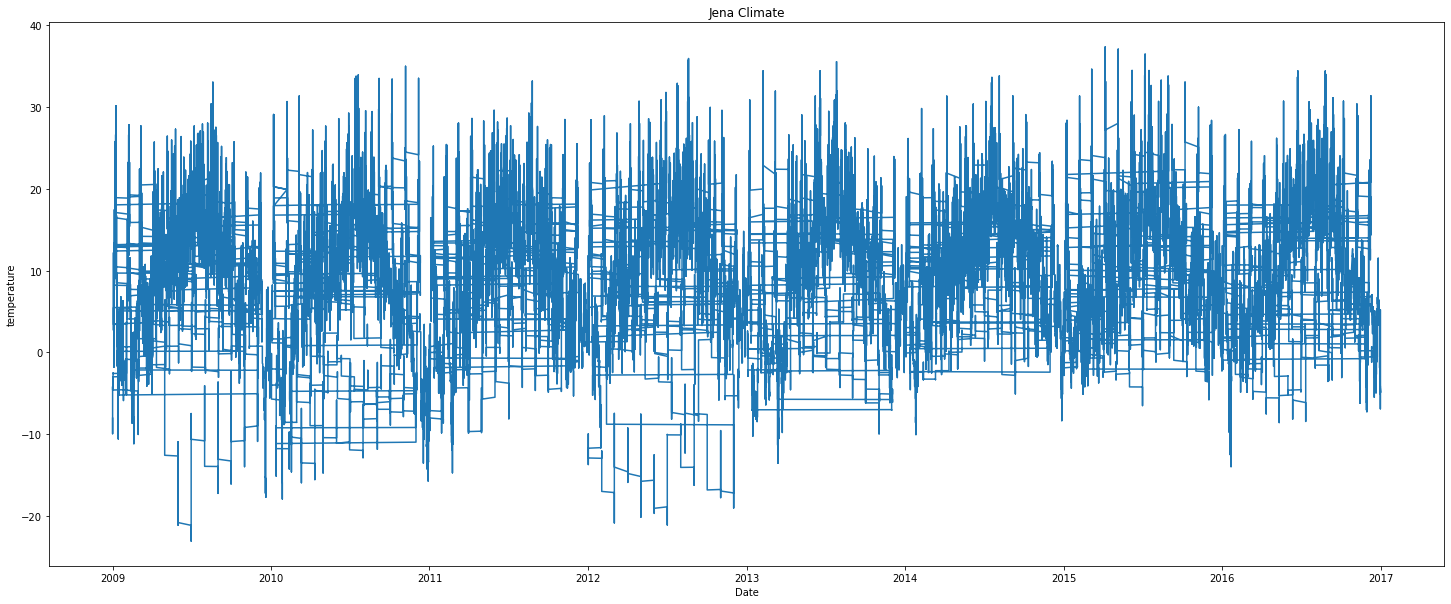

In [9]:
# plot data

plt.figure(figsize=(25,10))
plt.plot(jena_f)
plt.title('Jena Climate')
plt.xlabel('Date')
plt.ylabel('temperature')
plt.show()

In [10]:
# get values of data 

date = df['Date Time'].values.astype(float)
tmp = df['T_degC'].values.astype(float)

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Validation set sebesar 20% dari total dataset.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(tmp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

336440 84111


In [13]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [15]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [17]:
max = df['T_degC'].max()
print('Maximal value : ' )
print(max)

Maximal value : 
37.28


In [18]:
min = df['T_degC'].min()
print('Minimal Value : ')
print(min)

Minimal Value : 
-23.01


In [19]:
x = (37.28 - (-23.01)) * (1 / 100)
print(x)

0.6029000000000001


In [20]:
# callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model less than 10% of data scale")
callbacks = myCallback()

In [21]:
tf.keras.backend.set_floatx('float64')
number_epochs = 10

history = model.fit(data_x_train,
                    epochs=number_epochs,
                    validation_data=data_x_test,
                    batch_size=64,
                    shuffle=False,
                    callbacks=[callbacks])

Epoch 1/10
3364/3364 [==============================] - 172s 41ms/step - loss: 6.7053 - mae: 7.1838 - val_loss: 3.8354 - val_mae: 4.3031
Epoch 2/10
3364/3364 [==============================] - 136s 40ms/step - loss: 3.3658 - mae: 3.8297 - val_loss: 3.2866 - val_mae: 3.7457
Epoch 3/10
3364/3364 [==============================] - 137s 40ms/step - loss: 3.1049 - mae: 3.5658 - val_loss: 3.1174 - val_mae: 3.5737
Epoch 4/10
3364/3364 [==============================] - 136s 40ms/step - loss: 2.9814 - mae: 3.4405 - val_loss: 3.0250 - val_mae: 3.4792
Epoch 5/10
3364/3364 [==============================] - 136s 40ms/step - loss: 2.8910 - mae: 3.3483 - val_loss: 2.9535 - val_mae: 3.4057
Epoch 6/10
3364/3364 [==============================] - 137s 40ms/step - loss: 2.8190 - mae: 3.2747 - val_loss: 2.8905 - val_mae: 3.3410
Epoch 7/10
3364/3364 [==============================] - 136s 40ms/step - loss: 2.7531 - mae: 3.2071 - val_loss: 2.8299 - val_mae: 3.2785
Epoch 8/10
3364/3364 [===================

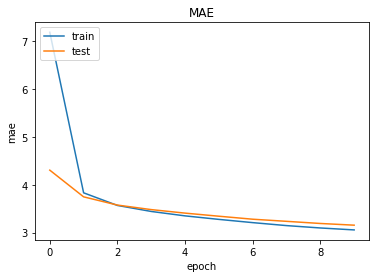

In [22]:
# MAE Plot

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

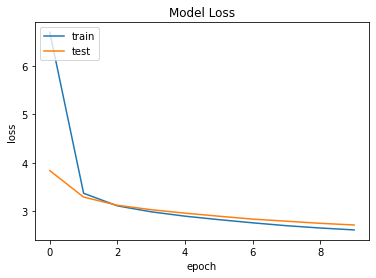

In [23]:
# loss plot

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Rokhmat Febrianto

Bergabung sejak 16 Mar 2021

Kabupaten Sidoarjo, Jawa Timur 